# Assignment 6

[3 points] Delelop language model, which generates texts from wikipedia.   
Use WikiText-2 dataset, also available in `torchtext.datasets`.  
Use `sentencepiece` or `tokenizers` library for text tokenization. Pay attention to vocab size, probably subword tokens are better.    
Your model should be autogressive RNN.  
[1 point] Plot train and validation loss depending on the number of iterations of gradient decent.  
[1 point] Try to use together (`sentencepiece` or `tokenizers`), `torchtext.datasets`, and `torchtext.data.BPTTIterator`  

<img src="https://github.com/thedenaas/hse_seminars/blob/master/2019/seminar_9/images/lm.jpg?raw=1" style="height:300px">

Text generation should be terminated when either max length is reached or terminal symbol is generated.  
Explore several inference techniques:
1. [1 point] Argmax
1. [1 point] Beamsearch
1. [1 point] Sampling from probabilty distribution with temperature
1. [1 point] Nucleus sampling
1. [1 point] Top-k sampling


For every method you should provide implemented code and generated examples. Each example must contain at least 10 words (not subword tokens).

Readings:
https://arxiv.org/abs/1904.09751

In [1]:
!pip install tokenizers

     |████████████████████████████████| 3.7MB 1.4MB/s 


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
from tqdm import tqdm_notebook

import torch
import torch.nn as nn
import torch.optim as optim

from torchtext.datasets import WikiText2
from torchtext import data

from tokenizers import SentencePieceBPETokenizer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [0]:
BATCH_SIZE = 64
MAX_SEQ_LENGTH = 35

In [4]:
!wget https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip
!unzip 'wikitext-2-v1.zip'

--2020-02-03 10:20:56--  https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-2-v1.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.10.133
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.10.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4475746 (4.3M) [application/zip]
Saving to: ‘wikitext-2-v1.zip’

wikitext-2-v1.zip   100%[===================>]   4.27M  2.90MB/s    in 1.5s    

2020-02-03 10:20:59 (2.90 MB/s) - ‘wikitext-2-v1.zip’ saved [4475746/4475746]

Archive:  wikitext-2-v1.zip
   creating: wikitext-2/
  inflating: wikitext-2/wiki.test.tokens  
  inflating: wikitext-2/wiki.valid.tokens  
  inflating: wikitext-2/wiki.train.tokens  


# Data preprocessing and loading

First, we need to train sentencepiece tokenizer on our data. 

Based on: http://mlexplained.com/2018/02/15/language-modeling-tutorial-in-torchtext-practical-torchtext-part-2/

In [0]:
def open_file(name):
    with open(name, 'r') as file:
        text = file.read()
    return text

def save_file(text, name):
    with open('/content/{}.txt'.format(name), 'w') as file:
        file.write(text)

def clean_data(text):
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'&[a-z]{0,7};', ' ', text)
    text = re.sub(r'\s{2,10}', ' ', text)
    text = re.sub(r'\s{2,10}', ' ', text)
    text = re.sub(r'\\\\x\d{1,4}', '', text)
    text = re.sub(r'=\s.{3,15}=\s', '', text)
    text = re.sub(r'\s@', ' ', text)
    text = re.sub(r'@\s', ' ', text)
    return text

def special_tokens(text):
    """
    Adds <eos> token if eos symbol occures.
    """
    eos = [' .', ' !', ' ?', ' ? !', ' \'n']
    eos_token = '<eos> <start>'
    for element in eos:
        text = text.replace(element, ' ' + eos_token + ' ')
    text = re.sub(r'<start>\s{2,10}<eos>', ' ', text)
    while '  ' in text:
        text = re.sub(r'\s{2,10}', ' ', text)
    text = '<start> ' + text
    return text

In [0]:
wiki_train = open_file('/content/wikitext-2/wiki.train.tokens')
wiki_train = clean_data(wiki_train)
wiki_train = special_tokens(wiki_train)
save_file(wiki_train, 'wiki_train')

wiki_valid = open_file('/content/wikitext-2/wiki.valid.tokens')
wiki_valid = clean_data(wiki_valid)
wiki_valid = special_tokens(wiki_valid)
save_file(wiki_train, 'wiki_valid')

No test data used to train tokenizer and to build vocab. 

In [13]:
tokenizer = SentencePieceBPETokenizer()
tokenizer.train(['/content/wiki_train.txt', '/content/wiki_valid.txt'], special_tokens=['<eos>', '<unk>', '<start>'], vocab_size=30000)
tokenizer

Tokenizer(vocabulary_size=30000, model=SentencePieceBPE, unk_token=<unk>, replacement=▁, add_prefix_space=True, dropout=None)

In [0]:
def tokenize(text, tokenizer=tokenizer):
    text = clean_data(text)
    text = special_tokens(text)
    return tokenizer.encode(text).tokens

In [15]:
TEXT = data.Field(sequential=True, include_lengths=False, batch_first=True, tokenize=tokenize,lower=True, pad_first=True)
train, valid, test = WikiText2.splits(TEXT)

TEXT.build_vocab(train, valid, unk_init = torch.Tensor.normal_, vectors='glove.6B.200d')
vocab = TEXT.vocab

print('Vocab size:', len(TEXT.vocab.itos))
TEXT.vocab.itos[:10]

downloading wikitext-2-v1.zip


wikitext-2-v1.zip: 100%|██████████| 4.48M/4.48M [00:01<00:00, 2.73MB/s]


extracting


.vector_cache/glove.6B.zip: 862MB [06:30, 2.21MB/s]                           
100%|█████████▉| 399206/400000 [00:37<00:00, 10804.71it/s]

Vocab size: 22825


['<unk>', '<pad>', '▁', '▁the', '<eos>', '<start>', '▁,', '▁of', '▁and', '▁in']

In [16]:
train_iterator, valid_iterator, test_iterator = data.BPTTIterator.splits(
    (train, valid, test),
    batch_size=BATCH_SIZE,
    bptt_len=40,
    device=device,
    repeat=False)

b = next(iter(train_iterator)); vars(b).keys()

dict_keys(['batch_size', 'dataset', 'fields', 'text', 'target'])

# Model

In [0]:
class MyModel(nn.Module):
    
    def __init__(self, vocab_size, embed_size, hidden_size):
        super(MyModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        
        self.rnn = nn.LSTM(input_size=embed_size,
                           hidden_size=hidden_size,
                           bidirectional=True,
                           batch_first=True,
                          )
        
        self.fc = nn.Linear(hidden_size * 2, vocab_size)
        
        self.init_weights()
        
    def init_weights(self):
        nn.init.uniform_(self.embedding.weight)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)
        
    def forward(self, batch):
        
        x = batch.text.T if hasattr(batch, 'text') else batch # because later we pass Tensor here
        
        x = self.embedding(x)           
        x, _ = self.rnn(x)
        x = self.fc(x)

        return x.transpose(1,2)

In [0]:
def _train_epoch(model, iterator, optimizer, criterion, curr_epoch):

    model.train()

    running_loss = 0
    losses = []

    n_batches = len(iterator)
    iterator = tqdm_notebook(iterator, total=n_batches, desc='epoch %d' % (curr_epoch), leave=True)

    for i, batch in enumerate(iterator):
        optimizer.zero_grad()

        pred = model(batch)
        loss = criterion(pred, batch.target.T)
        losses.append(loss.item())
        loss.backward()
        optimizer.step()

        curr_loss = loss.data.cpu().detach().item()
        
        loss_smoothing = i / (i+1)
        running_loss = loss_smoothing * running_loss + (1 - loss_smoothing) * curr_loss

        iterator.set_postfix(loss='%.5f' % running_loss)

    return running_loss, losses

def _test_epoch(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    losses = []

    n_batches = len(iterator)
    with torch.no_grad():
        for batch in iterator:
            pred = model(batch)
            loss = criterion(pred, batch.target.T)
            losses.append(loss.item())
            epoch_loss += loss.data.item()

    return epoch_loss / n_batches, losses

def nn_train(model, train_iterator, valid_iterator, criterion, optimizer, n_epochs=100,
          scheduler=None, early_stopping=0):

    model = model.to(device)
    criterion = criterion.to(device)
    
    prev_loss = 100500
    es_epochs = 0
    best_epoch = None
    history = pd.DataFrame()

    train_losses = []
    valid_losses = []

    for epoch in range(n_epochs):
        train_loss, epoch_tl = _train_epoch(model, train_iterator, optimizer, criterion, epoch)
        valid_loss,  epoch_vl = _test_epoch(model, valid_iterator, criterion)
        
        train_losses.extend(epoch_tl)
        valid_losses.extend(epoch_vl)

        print('validation loss %.5f' % valid_loss)

        record = {'epoch': epoch, 'train_loss': train_loss, 'valid_loss': valid_loss}
        history = history.append(record, ignore_index=True)

        if early_stopping > 0:
            if valid_loss > prev_loss:
                es_epochs += 1
            else:
                es_epochs = 0

            if es_epochs >= early_stopping:
                best_epoch = history[history.valid_loss == history.valid_loss.min()].iloc[0]
                print('Early stopping! best epoch: %d val %.5f' % (best_epoch['epoch'], best_epoch['valid_loss']))
                break

            prev_loss = min(prev_loss, valid_loss)
    return history, train_losses, valid_losses

In [0]:
model = MyModel(vocab_size=len(TEXT.vocab.itos),
                embed_size=200,
                hidden_size=128,
               )

model.embedding.weight.data.copy_(TEXT.vocab.vectors);

optimizer = optim.Adam(model.parameters())
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5)
criterion = nn.CrossEntropyLoss(ignore_index=1)

In [22]:
history, train_losses, valid_losses = nn_train(model, train_iterator, valid_iterator, criterion, optimizer, scheduler=scheduler, 
        n_epochs=10, early_stopping=2)

validation loss 1.56232


validation loss 0.54304


validation loss 0.29360


validation loss 0.22045


validation loss 0.19572


validation loss 0.18533


validation loss 0.18088


validation loss 0.17955


validation loss 0.17993


validation loss 0.18112
Early stopping! best epoch: 7 val 0.17955


In [0]:
torch.save(model.state_dict(), '/content/model')

In [24]:
history

,epoch,train_loss,valid_loss
0,0.0,3.533490,1.562319
1,1.0,1.016376,0.543039
2,2.0,0.368796,0.293597
3,3.0,0.186225,0.220449
4,4.0,0.133631,0.195716
5,5.0,0.112839,0.185334
6,6.0,0.099077,0.180882
7,7.0,0.087176,0.179545
8,8.0,0.076539,0.179930
9,9.0,0.067361,0.181119


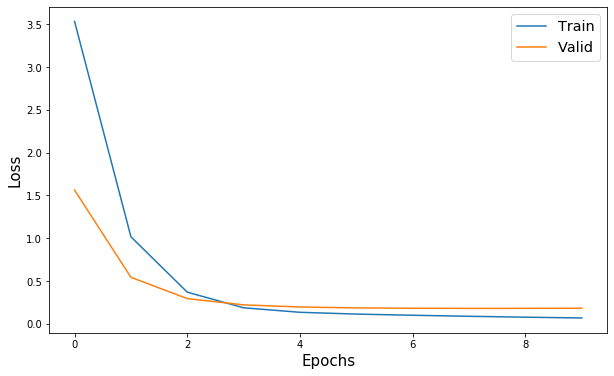

In [25]:
plt.figure(figsize=(10,6))
plt.plot(np.arange(len(history['train_loss'])), history['train_loss'], label='Train')
plt.plot(np.arange(len(history['valid_loss'])), history['valid_loss'], label='Valid')
plt.xlabel('Epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.legend(fontsize='x-large')
plt.show()

In [0]:
# because of different lengths I make validation_losses more like training losses to plot them in the same scale
new_val = [el for el in valid_losses for i in range(10)]

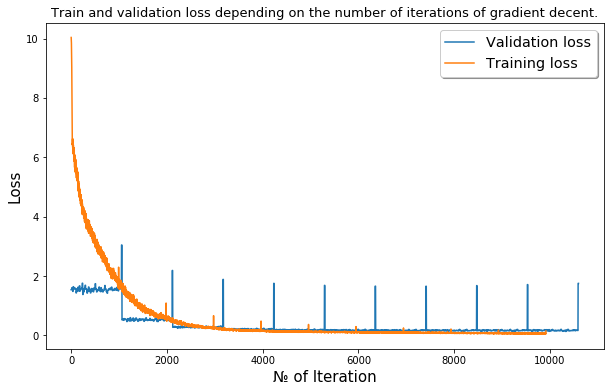

In [27]:
plt.figure(figsize=(10,6))
plt.plot(new_val, label='Validation loss')
plt.plot(train_losses, label='Training loss')
plt.ylabel('Loss', fontsize=15)
plt.xlabel('№ of Iteration', fontsize=15)
plt.title('Train and validation loss depending on the number of iterations of gradient decent.', fontsize=13)
plt.legend(fontsize='x-large', shadow=True)
plt.show()

# Prediction

In [0]:
def decode(sequence):
    return [vocab.itos[token] for token in sequence]

In [0]:
def make_text(sequence):
    
    text = ''

    for element in sequence:
        if element.startswith('▁'):
            text += element[1:] if len(element) > 1 else ' '
        else:
            text += element
        text += ' '
    text = re.sub(r'\s{2,5}', ' ', text)
    return text

In [0]:
def predict(start_tokens, prediction_type, 
            model=model, max_length=MAX_SEQ_LENGTH, eos_id=vocab.stoi['<eos>']):
    """
    Returns sequence of ids
    """
    
    result_ids = start_tokens.tolist()
    counter = 0
    
    start_tokens = start_tokens.unsqueeze(0)

    with torch.no_grad():
        while counter < max_length:        
            
            pred = model(start_tokens) # size: batch_size, vocab_size, seq_length
            pred = pred.transpose(1,2) # size: batch_size, seq_length, vocab_size
            pred_id = prediction_type(pred) #TOKEN_ID
            result_ids.append(pred_id)
            start_tokens = torch.cat((start_tokens, 
                                      torch.tensor([pred_id]).unsqueeze(0).T.to(device)), 
                                      dim=1)

            counter += 1

            if (counter >= 10) and (pred_id == eos_id):
                return result_ids
    return result_ids

In [66]:
to_predict = [] # these are the sentences we will be predicting on
for i, batch in enumerate(test_iterator):
    if i % 14 == 0 and i > 0:
        to_predict.append(batch.text[:6, 1])
to_predict.append(torch.tensor([5]).to(device))

for example in to_predict:
    print(decode(example))

['▁language', '▁makes', '▁use', '▁of', '▁all', '▁the']
['▁for', '▁his', '▁use', '▁of', '▁simple', '▁,']
['▁of', '▁', '<unk>', '▁poetry', '▁,', '▁asked']
['▁through', '▁very', '▁well', '▁in', '▁translation', '▁"']
['▁one', '▁dire', 'ction', '▁performed', '▁"', '▁kiss']
['▁the', '▁number', '▁was', '▁released', '▁digitally', '▁in']
['▁', '▁=', '▁=', '▁commercial', '▁performance', '▁=']
['▁"', '▁live', '▁while', '▁we', "▁'re", '▁young']
['<start>']


In [0]:
def show_predictions(to_predict, pred_func, model, decode=decode, make_text=make_text):
    for el in to_predict:
        text_ids = predict(start_tokens=el, prediction_type=pred_func, model=model)
        tokens_list = decode(text_ids)
        
        initial = tokens_list[:len(el)]
        generated = tokens_list[len(el):]
        print('Initial Text: ', make_text(initial))
        print('Generated Text: ', make_text(generated))
        print('')

## [1 point] Argmax prediction

In [0]:
def argmax_pred(tensor_out):
    tokens_probs = torch.softmax(tensor_out, dim=2)
    pred_id = torch.argmax(tokens_probs[0, -1, :]).item()
    return pred_id

In [68]:
show_predictions(to_predict, argmax_pred, model)

Initial Text:  language makes use of all the 
Generated Text:   <unk> of the <unk> of the <unk> of the <unk> of the <unk> of the <unk> of the <unk> of the <unk> of the <unk> of 

Initial Text:  for his use of simple , 
Generated Text:  and his ph obia , the " <unk> " <unk> " <eos> 

Initial Text:  of <unk> poetry , asked 
Generated Text:   <eos> <start> <eos> <start> <eos> 

Initial Text:  through very well in translation " 
Generated Text:  , which was " <unk> " <eos> <start> " <eos> 

Initial Text:  one dire ction performed " kiss 
Generated Text:  at the " <unk> " , the <unk> of the <unk> of the <unk> of the <unk> of the <unk> of the <unk> of the <unk> of 

Initial Text:  the number was released digitally in 
Generated Text:  the united states <eos> <start> <eos> <start> <eos> 

Initial Text:   = = commercial performance = 
Generated Text:  = <eos> <start> <eos> <start> <eos> 

Initial Text:  " live while we 're young 
Generated Text:  leave the <unk> of the <unk> of the <unk> of th

## [1 point] Beamsearch

In [0]:
def beam_search(input_seq, model=model, max_length=MAX_SEQ_LENGTH, k=3, end_token=vocab.stoi['<eos>']):
    """
    imput_seq:  Torch tensor 1d
    return: List of k sequences of token_ids.
    """
    beam = [(input_seq, 0)]
    start_tokens = input_seq.unsqueeze(0)
    
    with torch.no_grad():
        counter = 0        
        while counter < max_length:

            candidates = []
            counter += 1

            for start, prob in beam:
        
                if (start[-1] == end_token) and counter >= 15:
                    candidates.append(start)
                
                else:
                    pred = model(start.unsqueeze(0)) #start_tokens
                    pred = pred.transpose(1,2) # (batch_size, seq_length, vocab_size)

                    sorted_idx = torch.argsort(pred, dim=2, descending=True)[0,-1,:][:k]
                    sorted_logits = torch.sort(pred, dim=2, descending=True).values[0,-1,:][:k]

                    candidates += [(torch.cat((start, sorted_idx[i].unsqueeze(0))), 
                                    prob + sorted_logits[i].item()) for  i in range(k)]
            beam = sorted(candidates, key=lambda x:x[1])[:k] 
    return beam

In [89]:
for ind, el in enumerate(to_predict):
        beams = beam_search(input_seq=el)
        print('===== EXAMPLE № {} ====='.format(ind))
        for element in beams:
            element = decode(element[0].tolist())
            initial = element[:len(el)]
            generated = element[len(el):]
            print('Initial Text: ', make_text(initial))
            print('Generated Text: ', make_text(generated))
            print(' ')

===== EXAMPLE № 0 =====
Initial Text:  language makes use of all the 
Generated Text:  " ჯ 's death ჯ ჯ and the first conservation conservation conservation of a new jetport orld in which was ს the film the film , and his only 
 
Initial Text:  language makes use of all the 
Generated Text:  " ჯ 's death ჯ ჯ and the first conservation conservation conservation of a new jetport orld in which was ს the film the film , and his ph 
 
Initial Text:  language makes use of all the 
Generated Text:  " ჯ 's death ჯ ჯ and the first conservation conservation conservation of a new jetport orld in which was ს the film the film the film , 
 
===== EXAMPLE № 1 =====
Initial Text:  for his use of simple , 
Generated Text:  the cathedral was in an interview of which primordial and then , the film 's death , was a normal one that time the film ჯ , a small fishing of the film 
 
Initial Text:  for his use of simple , 
Generated Text:  the cathedral was in an interview of which primordial and then , the f

## [1 point] Sampling from probabilty distribution with temperature

Based on: https://towardsdatascience.com/how-to-sample-from-language-models-682bceb97277

In [0]:
def sampling_with_temperature(tensor_out, temperature=.5): #size: batch_size, seq_length, vocab_size
    tokens_probs = torch.softmax(tensor_out/temperature, dim=2)
    pred_id = np.random.choice(len(vocab), 1, p=tokens_probs[0,-1,:].cpu().numpy())
    return pred_id[0]

In [70]:
show_predictions(to_predict, sampling_with_temperature, model)

Initial Text:  language makes use of all the 
Generated Text:   <unk> of the " <unk> " <eos> 

Initial Text:  for his use of simple , 
Generated Text:  and the publicity was the <unk> of the <unk> ( <unk> <unk> <unk> - <unk> <unk> of <unk> , and is a series of anti - 

Initial Text:  of <unk> poetry , asked 
Generated Text:  why , and the isle , which is similar to the new zealand bird bird at the united states , and the more direct result , the film was written by the fitwatch of 

Initial Text:  through very well in translation " 
Generated Text:  , which is not known about this time <eos> 

Initial Text:  one dire ction performed " kiss 
Generated Text:  ol éon ators , and beh avior with the first season finale in the united states to the morning of the new york times <eos> 

Initial Text:  the number was released digitally in 
Generated Text:  the <unk> of the character 's predicted at the the new york times in the <unk> <eos> 

Initial Text:   = = commercial performance = 
Generat

In [71]:
def sampling_with_temperature(tensor_out, temperature=.7): # with higher temperature generated sentences are more diverse
    tokens_probs = torch.softmax(tensor_out/temperature, dim=2)
    pred_id = np.random.choice(len(vocab), 1, p=tokens_probs[0,-1,:].cpu().numpy())
    return pred_id[0]

show_predictions(to_predict, sampling_with_temperature, model)

Initial Text:  language makes use of all the 
Generated Text:   <unk> of deities who in the <unk> of the police officers officers disagreed of the night , as a white sox , his book <eos> 

Initial Text:  for his use of simple , 
Generated Text:  olivier 's overall episode ever written by john f. ford <eos> 

Initial Text:  of <unk> poetry , asked 
Generated Text:   <eos> <start> <eos> <start> fowler scored 12 and we may be more than the aid and the core of the year <eos> 

Initial Text:  through very well in translation " 
Generated Text:  , which is a scene in the winter <eos> 

Initial Text:  one dire ction performed " kiss 
Generated Text:  at the " a trial trial of <unk> " <eos> 

Initial Text:  the number was released digitally in 
Generated Text:  the uk singles , intrigue on average <unk> — yoko had worked on october 19 september , and the club , and haitian the spacecraft passed the east of the family yacht - destruct 

Initial Text:   = = commercial performance = 
Generated Te

## [1 point] Nucleus sampling

In [72]:
def nucleus_pred(tensor_out, p=0.8):

    sorted_idx = torch.argsort(tensor_out, dim=2, descending=True)[0,-1,:]
    sorted_logits = torch.sort(tensor_out, dim=2, descending=True).values[0,-1,:]
    
    relative_probs = torch.cumsum(torch.softmax(sorted_logits, dim=-1), dim=0)
    mask = relative_probs >= p 
    ind = torch.nonzero(mask)
    ind = ind[-1,:]

    to_random = sorted_idx[:ind+1]
    
    pred_id = np.random.choice(to_random.cpu().numpy(), 1, p=torch.softmax(sorted_logits[:ind+1], dim=0).cpu().numpy())
    return pred_id[0]
show_predictions(to_predict,nucleus_pred, model)

Initial Text:  language makes use of all the 
Generated Text:  environment accord sought in the sea , mon rically using a does and logic music <eos> 

Initial Text:  for his use of simple , 
Generated Text:  then moved to photograph the plot <eos> <start> it was dominated by a quasi arising between them and encouraged in which was less important in territory , were two <eos> 

Initial Text:  of <unk> poetry , asked 
Generated Text:  was 4 later , for other kind ness , so , winning an 125 towards who little social dist krishna " president or <unk> to the various league video concept <eos> 

Initial Text:  through very well in translation " 
Generated Text:  , but couldn 't you something we did not really our next as a result , bridge <eos> 

Initial Text:  one dire ction performed " kiss 
Generated Text:  worked as it pushes one south of croatia - billed in machinery one long sin fun " at number - <unk> ) <eos> 

Initial Text:  the number was released digitally in 
Generated Text:  the 

In [73]:
def nucleus_pred(tensor_out, p=0.97):

    sorted_idx = torch.argsort(tensor_out, dim=2, descending=True)[0,-1,:]
    sorted_logits = torch.sort(tensor_out, dim=2, descending=True).values[0,-1,:]
    
    relative_probs = torch.cumsum(torch.softmax(sorted_logits, dim=-1), dim=0)
    mask = relative_probs >= p 
    ind = torch.nonzero(mask)
    ind = ind[-1,:]

    to_random = sorted_idx[:ind+1]
    
    pred_id = np.random.choice(to_random.cpu().numpy(), 1, p=torch.softmax(sorted_logits[:ind+1], dim=0).cpu().numpy())
    return pred_id[0]
show_predictions(to_predict,nucleus_pred, model)

Initial Text:  language makes use of all the 
Generated Text:  period , so - miranic als " were allowed sales new , california , " the kiss is communal in asomtavruli to his separate fledging and harvey ach baroque baroque us 1 and eight institute 

Initial Text:  for his use of simple , 
Generated Text:  1993 on the morning , viewing in the average daily mail , the film was inspired inspired by a group called the ulan agent of anti - <unk> <eos> 

Initial Text:  of <unk> poetry , asked 
Generated Text:   <eos> <start> although booms forms of the moon and is the <unk> of the <unk> to support : <unk> weather it as a more commonly portrayed of subs erv and 

Initial Text:  through very well in translation " 
Generated Text:  and zanzib spheres <unk> adaptations as the heavy normal fleet 's principal tapes for the somalia <eos> 

Initial Text:  one dire ction performed " kiss 
Generated Text:  at the economy has traditional traditional use " , " <unk> - yield " that " <eos> 

Initial Text

## [1 point] Top-k sampling

In [74]:
def top_k_pred(logits, k=15):

    sorted_idx = torch.argsort(logits, dim=2, descending=True)[0,-1,:][:k]
    sorted_logits = torch.sort(logits, dim=2, descending=True).values[0,-1,:][:k]
    relative_probs = torch.softmax(sorted_logits, dim=0)

    pred_id = np.random.choice(sorted_idx.cpu().numpy(), 1, p=relative_probs.cpu().numpy())
    return pred_id[0]

show_predictions(to_predict,top_k_pred, model)

Initial Text:  language makes use of all the 
Generated Text:  " " , while attempting to a " holocaust " the use of the " a result of the lead to have been observed to humans , the film 's icy style <eos> 

Initial Text:  for his use of simple , 
Generated Text:  he says that the <unk> " <unk> <unk> to the new territory for the <unk> of the <unk> in the <unk> of <unk> , " , and thus 

Initial Text:  of <unk> poetry , asked 
Generated Text:  mut , and the film was " , which was not used the same that time the island is the first game by howard , it was one of the <unk> of the 

Initial Text:  through very well in translation " 
Generated Text:  , while frank oliver cromwell of the " is shown can something something very " , " that " as well - muscular fire " <eos> 

Initial Text:  one dire ction performed " kiss 
Generated Text:  is to the " a single fruit " <eos> 

Initial Text:  the number was released digitally in 
Generated Text:  the united states in the year , he will pick and mig

In [75]:
def top_k_pred(tensor_out, k=40):

    sorted_idx = torch.argsort(tensor_out, dim=2, descending=True)[0,-1,:][:k]
    sorted_logits = torch.sort(tensor_out, dim=2, descending=True).values[0,-1,:][:k]
    relative_probs = torch.softmax(sorted_logits, dim=0)

    pred_id = np.random.choice(sorted_idx.cpu().numpy(), 1, p=relative_probs.cpu().numpy())
    return pred_id[0]

show_predictions(to_predict,top_k_pred, model)

Initial Text:  language makes use of all the 
Generated Text:  first position on the french upper and were not found in india <eos> 

Initial Text:  for his use of simple , 
Generated Text:  allowing <eos> <start> <eos> <start> as a military science - year term 3 – 0 win against romani <eos> 

Initial Text:  of <unk> poetry , asked 
Generated Text:  he proposed anderson spent him of a chapel bird of pop pop smash that a major national championship for immigrants of reducing being in october 2005 , and thus , a six - oriented period 

Initial Text:  through very well in translation " 
Generated Text:   <eos> <start> " ( <unk> characterized in the other times in which he can kill in the global of june <eos> 

Initial Text:  one dire ction performed " kiss 
Generated Text:  to his integrity <eos> <start> vargas from her character wore however , <unk> 250 alligators , which the general is located about the moon was in which were not used in 1891 

Initial Text:  the number was released dig